# Build Target Model

Here we work to expand our on target rules to include information about the target site.
We consider three feature classes when building this model:

1. Position within a gene
  1. Guide orientation relative to the direction of transcription
  2. Distance to the end of the CDS
  3. Distance to the start of the CDS
  4. Percent of CDS
2. Protein Domain information:
  1. Whether a guide targets within an annotated protein domain
3. Sequence conservation:
  1. Conservation of 3 nucleotide preceding the cut site
  2. "" succeeding the cut site
  3. Conservation of
4. Amino acid information:
  1. Position independent one-mers
  2. "" two-mers
  3. Position dependent one-mers


In [57]:
import pandas as pd
from datasets import dataset_list
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import clone
import joblib
import sglearn
import seaborn as sns
from tqdm import tqdm
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from core import (get_predictive_performance,
                  plot_pearson_heatmap,
                  plot_relative_performance)
import plotnine as gg
import shap

In [37]:
def get_amino_acid_features(aa_seq_df, sg_designs, window=10):
    sg_aas = (aa_seq_df.merge(sg_designs[['Transcript Base', 'sgRNA Context Sequence', 'AA Index']], how='inner',
                                     on='Transcript Base'))
    padding = 'N' * window
    sg_aas['extended_seq'] = padding + sg_aas['seq'] + '*' + padding
    sg_aas['AA Index pad'] = sg_aas['AA Index'] + window
    # One-indexed
    sg_aas['seq_start'] = sg_aas['AA Index pad'] - window + 1
    sg_aas['seq_end'] = sg_aas['AA Index pad'] + window
    # Zero-indexed for python
    sg_aas['subsequence'] = sg_aas.apply(lambda row: row['extended_seq'][row['seq_start'] - 1:row['seq_end']],
                                         axis=1)
    aa_features = featurize_aa_seqs(sg_aas['subsequence'])
    aa_features_annot = pd.concat([sg_aas[['Transcript Base', 'sgRNA Context Sequence']].reset_index(drop=True),
                                   aa_features.reset_index(drop=True)], axis=1)
    return aa_features_annot

def get_position_features(sg_df):
    position_df = sg_df[['sgRNA Context Sequence', 'Transcript Base', 'Target Cut Length', 'Target Cut %']].copy()
    position_df = position_df.rename(columns={'Target Cut Length': 'dist. from start',
                                              'Target Cut %': 'dist. percent'})
    position_df['sense'] = sg_df['Orientation'] == 'sense'
    position_df['dist. from end'] = sg_df['Target Total Length'] - sg_df['Target Cut Length']
    return position_df


def train_test_model(X_train, y_train, model_name, fold, model, test_df, X_test):
    """Get predictions from train and test model

    :param train_df: DataFrame
    :param model_name: str, name of model
    :param fold: int
    :param model: model with a .fit function
    :param test_df: DataFrame
    :param X_test: DataFrame from sglearn.featurize_guides
    :return: DataFrame, same shape as test_df with columns prediction, model, fold
    """
    # TODO - modify featurization
    model.fit(X_train,  y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
    shap_importance = shap_df.abs().mean(0)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions, shap_importance


def get_fold_predictions(fold, fold_df, model_name, features,
                         base_model=LGBMRegressor(random_state=7, n_jobs=8)):
    """Get predictions for a given fold, allowing for each dataset to be trained separately,
    or multiple datasets trained together

    :param fold: int
    :param fold_df: DataFrame
    :param base_model: model with a .fit function
    :param features: list
    :param model_name: str optional, only relevant if top_datasets is specified
    :return: list of DataFrame, list of test predictions
    """
    train_df = fold_df.query('train == True').reset_index(drop=True)
    X_train = train_df[features]
    y_train = train_df['Residual Activity']
    test_df = fold_df.query('train == False').reset_index(drop=True)
    X_test = test_df[features]
    model = clone(base_model)
    dataset_test_predictions, shap_imp_series = train_test_model(X_train, y_train, model_name, fold,
                                                                 model, test_df, X_test)
    # return a list of length of one to combine with other training runs
    return dataset_test_predictions, shap_imp_series


def get_protein_domain_matrix(sg_design_df, protein_domains, categories=None):
    """Get binary matrix of protein domains

    :param sg_design_df: DataFrame, with columns ['Target Transcript', 'sgRNA Context Sequence', 'AA Index']
    :param protein_domains: DataFrame, with columns ['Parent', 'type']
    :param categories: list. list of database types to include
    :return: DataFrame, with binary features for protein domains
    """
    if categories is None:
        categories = ['Pfam', 'PANTHER', 'HAMAP', 'SuperFamily', 'TIGRfam', 'ncoils', 'Gene3D',
                      'Prosite_patterns', 'Seg', 'SignalP', 'TMHMM', 'MobiDBLite',
                      'PIRSF', 'PRINTS', 'Smart', 'Prosite_profiles']
    protein_domains = protein_domains[protein_domains['type'].isin(categories)]
    domain_model_matrix = sg_design_df[['Transcript Base', 'sgRNA Context Sequence', 'AA Index']].copy()
    domain_model_matrix = domain_model_matrix.merge(protein_domains.rename({'Parent': 'Transcript Base'}, axis=1),
                                                    how='inner', on='Transcript Base')
    domain_model_matrix = (domain_model_matrix[domain_model_matrix['AA Index'].between(domain_model_matrix['start'],
                                                                                       domain_model_matrix['end'])]
                           .copy())
    domain_model_matrix = domain_model_matrix[['Transcript Base', 'sgRNA Context Sequence', 'type']].drop_duplicates()
    domain_model_matrix['present'] = 1
    domain_model_matrix = (domain_model_matrix.pivot_table(values='present',
                                                           index=['Transcript Base', 'sgRNA Context Sequence'],
                                                           columns='type',
                                                           fill_value=0)
                           .reset_index())
    return domain_model_matrix


def get_conservation_features(sg_designs, conservation_df, conservation_column='ranked_conservation',
                              small_window=3, large_window=50):
    cons_features_list = []
    for i, row in tqdm(sg_designs.iterrows(), total=sg_designs.shape[0]):
        cut_pos = row['Target Cut Length']
        small_min, small_max = cut_pos - small_window + 1, cut_pos + small_window
        large_min, large_max = cut_pos - large_window + 1, cut_pos + large_window
        small_cons = (conservation_df.loc[(conservation_df['Transcript Base'] == row['Transcript Base']) &
                                          (conservation_df['target position'].between(small_min, small_max)),
                                          conservation_column]
                      .mean())
        large_cons =  (conservation_df.loc[(conservation_df['Transcript Base'] == row['Transcript Base']) &
                                          (conservation_df['target position'].between(large_min, large_max)),
                                          conservation_column]
                      .mean())
        cons_features = {'cons_' + str(small_window * 2): small_cons,
                         'cons_' + str(large_window * 2): large_cons,
                         'Transcript Base': row['Transcript Base'],
                         'sgRNA Context Sequence': row['sgRNA Context Sequence']}
        cons_features_list.append(cons_features)
    cons_features_df = pd.DataFrame(cons_features_list)
    return cons_features_df

def get_one_aa_pos(feature_dict, aa_sequence, aas, sequence_order):
    """One hot encode single amino acids

    :param feature_dict: dict, feature dictionary
    :param aa_sequence: str, amino acid sequence
    :param aas: list, list of amino acids
    :param sequence_order: list, position mapping for sequence
    """
    for i, pos in enumerate(sequence_order):
        curr_nt = aa_sequence[i]
        for aa in aas:
            key = pos + aa
            if curr_nt == aa:
                feature_dict[key] = 1
            else:
                feature_dict[key] = 0


def get_one_aa_frac(feature_dict, aa_sequence, aas):
    """Get fraction of single aa

    :param feature_dict: dict, feature dictionary
    :param aa_sequence: str, amino acid sequence
    :param aas: list, list of amino acids
    """
    for aa in aas:
        aa_frac = aa_sequence.count(aa) / len(aa_sequence)
        feature_dict[aa] = aa_frac


def get_two_aa_frac(feature_dict, aa_sequence, aas):
    """Get fraction of double aas

    :param feature_dict: dict, feature dictionary
    :param aa_sequence: str, amino acid sequence
    :param aas: list, list of amino acids
    """
    for aa1 in aas:
        for aa2 in aas:
            aa_frac = aa_sequence.count(aa1 + aa2) / (len(aa_sequence) - 1)
            feature_dict[aa1 + aa2] = aa_frac


def featurize_aa_seqs(aa_sequences, features=None):
    if features is None:
        features = ['Pos. Ind. 1mer', 'Pos. Ind. 2mer',
                    'Pos. Dep. 1mer']
    seq_len = len(aa_sequences[0])
    sequence_order = [str(int(x - seq_len/2 + 1)) for x in range(seq_len)]
    aas = ['A', 'C', 'D', 'E', 'F',
           'G', 'H', 'I', 'K', 'L',
           'M', 'N', 'P', 'Q', 'R',
           'S', 'T', 'V', 'W', 'Y', '*']
    feature_dict_list = []
    for i, aa_sequence in enumerate(aa_sequences):
        feature_dict = {}
        if 'Pos. Ind. 1mer' in features:
            get_one_aa_frac(feature_dict, aa_sequence, aas)
        if 'Pos. Ind. 2mer' in features:
            get_two_aa_frac(feature_dict, aa_sequence, aas)
        if 'Pos. Dep. 1mer' in features:
            get_one_aa_pos(feature_dict, aa_sequence, aas, sequence_order)
        feature_dict_list.append(feature_dict)
    feature_matrix = pd.DataFrame(feature_dict_list)
    feature_matrix.index = aa_sequences
    return feature_matrix

## Reading Data

In [3]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')

## Loading Datasets

In [4]:
train_data_list = list()
for ds in dataset_list:
    if (ds.name in train_data_names) and ds.endogenous:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()

## Building the Model Matrix

In [5]:
feature_set = set()

### Target Group for Cross Validation

In [6]:
sg_df_list = []
for ds in tqdm(train_data_list):
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    design_df = ds.get_designs()
    sg_df = sg_df.merge(design_df, how='inner',
                        on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

100%|██████████| 4/4 [00:18<00:00,  4.71s/it]


Context sequences with multiple targets: 0


In [7]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))

### Calculating Residuals

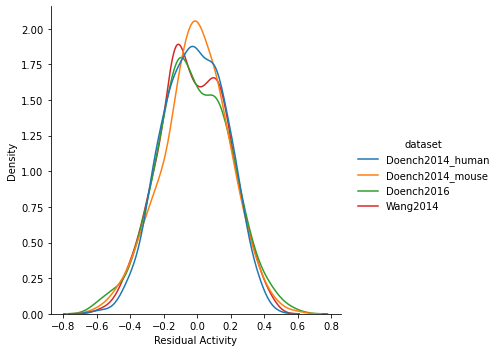

In [8]:
sg_df_class_groups['sgRNA Activity'] = (sg_df_class_groups.groupby('dataset')
                                        ['sgRNA Activity']
                                        .rank(pct=True))
seq_X = sglearn.featurize_guides(sg_df_class_groups['sgRNA Context Sequence'])
sg_df_class_groups['Rule Set 3'] = seq_model.predict(seq_X)
sg_df_class_groups['Residual Activity'] = sg_df_class_groups['sgRNA Activity'] - sg_df_class_groups['Rule Set 3']
sg_df_class_groups['AA Index'] = (sg_df_class_groups['Target Cut Length'] - 1) // 3 + 1
sg_df_class_groups['Transcript Base'] = sg_df_class_groups['Target Transcript'].str.split('.', expand=True)[0]
sns.displot(data=sg_df_class_groups, x='Residual Activity', hue='dataset',
            kind='kde', common_norm=False)

### Positional Features

In [9]:

position_features = get_position_features(sg_df_class_groups)
position_features

,sgRNA Context Sequence,Transcript Base,dist. from start,dist. percent,sense,dist. from end
0,TCAGAAATAATACCAACAACTGGAGGGAGA,ENST00000300060,2218,76.4,True,686
1,GTCAAACAGCTCACTGATCTGGGCCGGCGT,ENST00000300060,1398,48.1,False,1506
2,CATGAACCGCTGGACCCTGCAGATGGGCTT,ENST00000300060,1637,56.4,True,1267
3,CCAGAACGATCTCTTCAGCACATCAGGCAA,ENST00000300060,1841,63.4,True,1063
4,CGGTAACGATTCCACGCTTTACTTTGGTCC,ENST00000300060,203,7.0,False,2701
...,...,...,...,...,...,...
5717,TTCTTGGCATTCTTCCTCTTCACGCGGCCC,ENST00000391753,518,88.5,False,67
5718,AGTATGGGCTCCGGAACAAACGTGAGGTCT,ENST00000391753,121,20.7,True,464
5719,TCGATGTGCTTCTGGGAATCCAGGCGGACA,ENST00000391753,452,77.3,False,133
5720,CGACTTCTCTCTGCGCTCTCCCTACGGGGG,ENST00000391753,491,83.9,True,94


In [10]:
sg_df_class_groups_p = (sg_df_class_groups
                        .merge(position_features, how='left',
                               on=['Transcript Base', 'sgRNA Context Sequence']))
feature_set = feature_set | set(position_features.columns[2:])

### Protein Domain Features

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


[]

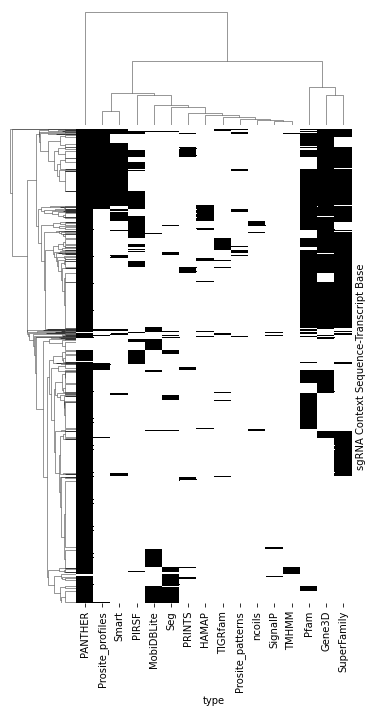

In [11]:
domain_model_matrix = get_protein_domain_matrix(sg_df_class_groups, protein_domains)
g = sns.clustermap(domain_model_matrix.set_index(['sgRNA Context Sequence', 'Transcript Base']),
                   cmap='binary', cbar_pos=None, metric='hamming')
g.ax_heatmap.get_yaxis().set_ticks([])

In [12]:
domain_sources = ['Pfam', 'PANTHER', 'HAMAP', 'SuperFamily', 'TIGRfam', 'ncoils', 'Gene3D',
                  'Prosite_patterns', 'Seg', 'SignalP', 'TMHMM', 'MobiDBLite',
                  'PIRSF', 'PRINTS', 'Smart', 'Prosite_profiles']
sg_df_class_groups_p_d = (sg_df_class_groups_p.merge(domain_model_matrix, how='left',
                                                     on=['sgRNA Context Sequence', 'Transcript Base']))
sg_df_class_groups_p_d[domain_sources] = sg_df_class_groups_p_d[domain_sources].fillna(0)
feature_set = feature_set | set(domain_sources)


### Conservation Features

In [13]:
transcript_bases = list(sg_df_class_groups['Target Transcript']
                        .str.split('.', expand=True)[0]
                        .unique())

In [14]:
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))
conservation_df['ranked_conservation'] = (conservation_df.groupby('Transcript Base')
                                          ['conservation']
                                          .rank(pct=True))


#### Conservation of Protein Domains

We'll merge conservation scores with the protein domain matrix to understand how protein domains are conserved

In [15]:
conservation_aa_i = conservation_df.copy()
conservation_aa_i['aa_i'] = conservation_aa_i['target position']//3 + 1
conservation_aa_i['loc_id'] = conservation_aa_i['Transcript Base'] + conservation_aa_i['aa_i'].astype(str)
# Filter sifts
conservation_domains = (conservation_aa_i.merge(protein_domains[protein_domains['type'] != 'sifts'],
                                                how='inner',
                                                left_on='Transcript Base', right_on='Parent'))
conservation_domains = (conservation_domains[conservation_domains['aa_i']
                        .between(conservation_domains['start'], conservation_domains['end'])])
conservation_non_domains = conservation_aa_i[~conservation_aa_i['loc_id'].isin(conservation_domains['loc_id'])]
conservation_cat = (pd.concat([conservation_domains, conservation_non_domains])
                    .reset_index(drop=True))
conservation_cat['type'] = conservation_cat['type'].fillna('None')
conservation_cat_summary = (conservation_cat.groupby(['type', 'genome'])
                            .agg(median_conservation = ('conservation', 'median'),
                                 n_obs = ('conservation', 'count'))
                            .reset_index()
                            .sort_values('median_conservation'))
conservation_cat_summary['name'] = (conservation_cat_summary['type'] +
                                    '(n=' +
                                    conservation_cat_summary['n_obs'].astype(str) +
                                    ')')
hg_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('hg')]
mm_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('mm')]
hg_conservation_cat = conservation_cat.merge(hg_conservation_cat_summary, how='inner')
hg_conservation_cat['name'] = pd.Categorical(hg_conservation_cat['name'],
                                             categories=hg_conservation_cat_summary['name'])
mm_conservation_cat = conservation_cat.merge(mm_conservation_cat_summary, how='inner')
mm_conservation_cat['name'] = pd.Categorical(mm_conservation_cat['name'],
                                             categories=mm_conservation_cat_summary['name'])

Text(0.5, 1.0, 'Human Training Data\nDomain Conservation')

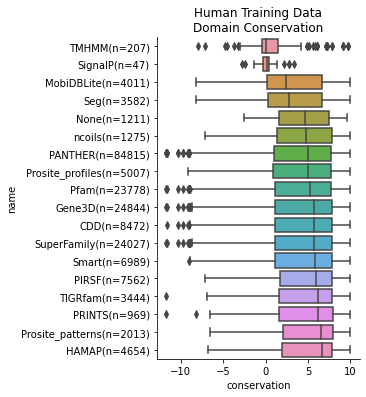

In [16]:
sns.catplot(data=hg_conservation_cat, y='name', x='conservation', kind='box')
plt.title('Human Training Data\nDomain Conservation')

Text(0.5, 1.0, 'Mouse Training Data\nDomain Conservation')

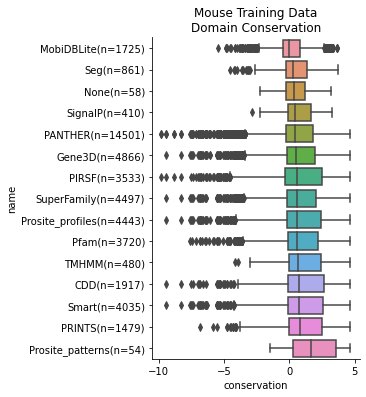

In [17]:
sns.catplot(data=mm_conservation_cat, y='name', x='conservation', kind='box')
plt.title('Mouse Training Data\nDomain Conservation')

#### Get Conservation Features

There are 39 sgRNAs with missing conservation scores which we will fill with a value of 0.5

In [18]:
cons_features_df = get_conservation_features(sg_df_class_groups, conservation_df)
cons_features_df.isna().sum()


100%|██████████| 5722/5722 [00:41<00:00, 139.38it/s]


cons_6                    39
cons_100                  39
Transcript Base            0
sgRNA Context Sequence     0
dtype: int64

In [19]:
sg_df_class_groups_p_d_c = (sg_df_class_groups_p_d
                            .merge(cons_features_df, how='left',
                            on=['Transcript Base', 'sgRNA Context Sequence']))
cons_cols =  ['cons_6', 'cons_100']
sg_df_class_groups_p_d_c[cons_cols] = sg_df_class_groups_p_d_c[cons_cols].fillna(0.5)
feature_set = feature_set | set(cons_cols)

### Amino Acid Features

In [20]:
# *TODO* incorporate filtering into database query

aa_seq_lens = (aa_seqs.rename({'query': 'Transcript Base'}, axis=1)
               .merge(sg_df_class_groups[['Transcript Base', 'Target Total Length']].drop_duplicates(),
                      how='inner', on='Transcript Base'))
aa_seq_lens['aa_seq_len'] = aa_seq_lens['seq'].str.len()
# Add One for stop codon
aa_seqs_filtered = aa_seq_lens[(aa_seq_lens['seq'].str.len() + 1)*3 == aa_seq_lens['Target Total Length']]
print('Filtered: ' + str(aa_seqs_filtered.shape[0] - aa_seq_lens.shape[0]) + ' mismatched seqs')

Filtered: 0 mismatched seqs


In [21]:
amino_acid_feature_df = get_amino_acid_features(aa_seqs_filtered, sg_df_class_groups)

In [22]:
sg_df_class_groups_p_d_c_a = (sg_df_class_groups_p_d_c
                              .merge(amino_acid_feature_df, how='left',
                                     on=['Transcript Base', 'sgRNA Context Sequence']))
aa_cols =  list(amino_acid_feature_df.keys()[2:])
sg_df_class_groups_p_d_c_a[aa_cols] = sg_df_class_groups_p_d_c_a[aa_cols].fillna(0)
feature_set = feature_set | set(aa_cols)

## Cross Validation iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

We define each dataset as a "class", such that the datasets are approximately equally distributed across
folds, constrained by the notion that each "group" or gene cannot appear in both the train and test set in a given fold.

First, we assign sgRNAs to genes, capitalizing gene-names from the mouse libraries, so they overlap with the human annotations.
We can see that every context sequence uniquely targets a gene in this dataset

We assign context sequences without a group to their own group. Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

We see again that the Doench Human and Mouse data do not appear in every train/test fold due to the relatively
small number of genes.

In [23]:
sg_feature_class_groups_df = sg_df_class_groups_p_d_c_a
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_feature_class_groups_df, sg_feature_class_groups_df.dataset,
                                                         sg_feature_class_groups_df.target)):
    train_df = sg_feature_class_groups_df.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_feature_class_groups_df.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n')
 .sort_values(['n', 'cv', 'dataset']))

,cv,dataset,n
19,0,Doench2014_human,1
18,1,Doench2014_human,1
17,2,Doench2014_human,1
16,2,Doench2014_mouse,1
1,0,Doench2014_mouse,2
15,0,Doench2016,2
14,0,Wang2014,2
13,1,Doench2014_mouse,2
12,1,Doench2016,2
11,1,Wang2014,2


- Training sizes vary from 5,258 - 4,253 sgRNAs
- Testing sizes vary from 1,469 - 464 sgRNAs

In [24]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
9,0,False,464
0,0,True,5258
6,1,False,1441
3,1,True,4281
8,2,False,1093
1,2,True,4629
5,3,False,1469
4,3,True,4253
7,4,False,1255
2,4,True,4467


Indeed each gene target (gene) only appears in one set in each fold

In [25]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Building Our Model

In [39]:
test_prediction_list = []
shap_importance_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    predictions, shap_importance = get_fold_predictions(fold, df, 'full_model',
                                                        features=list(feature_set))
    test_prediction_list.append(predictions)
    shap_importance_list.append(shap_importance)
    print('\n')

position_predictive_performance = get_predictive_performance(test_prediction_list)

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




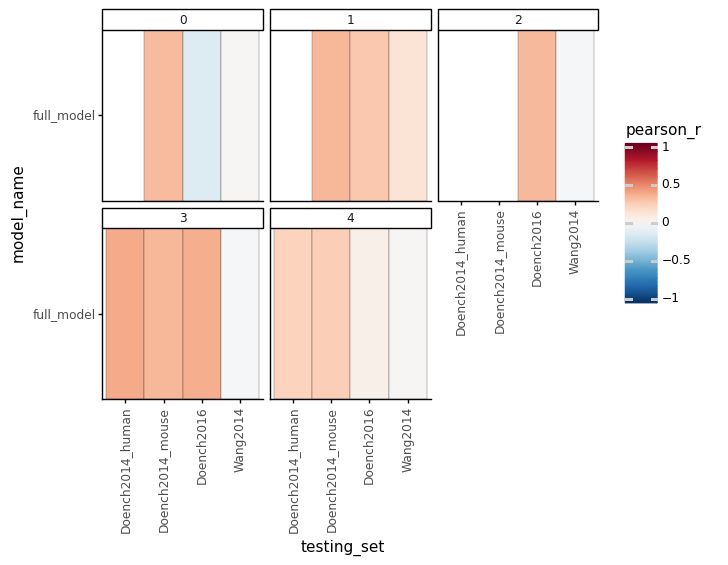

<ggplot: (8791294982940)>

In [40]:
plot_pearson_heatmap(position_predictive_performance)

On average we're performing better with positional features, but not across every dataset

In [41]:
position_predictive_performance['pearson_r'].agg(['mean', 'median'])

mean      0.179017
median    0.240213
Name: pearson_r, dtype: float64

In [64]:
feature_importance_df = (pd.concat(shap_importance_list, axis=1)
                         .reset_index()
                         .rename({'index': 'feature'}, axis=1)
                         .melt(id_vars='feature', var_name='fold', value_name='importance'))

avg_feature_importance = (feature_importance_df.groupby('feature')
                          .agg(avg_importance = ('importance', 'mean'),
                               std_importance = ('importance', 'std'))
                          .sort_values('avg_importance', ascending=False)
                          .reset_index())
avg_feature_importance['importance_high'] = avg_feature_importance['avg_importance'] + 2*avg_feature_importance['std_importance']
avg_feature_importance['importance_low'] = avg_feature_importance['avg_importance'] - 2*avg_feature_importance['std_importance']

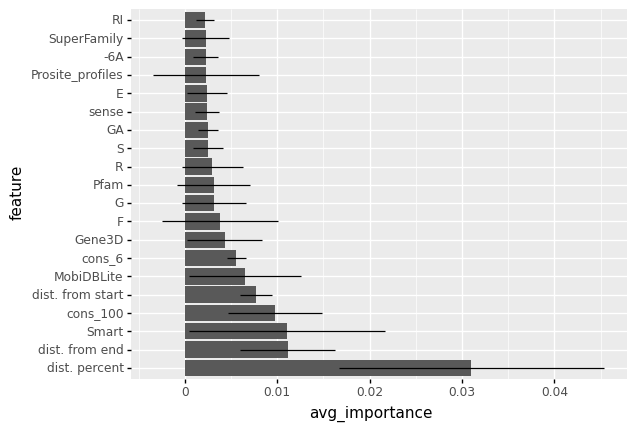

<ggplot: (8791236007933)>

In [69]:
top_n = 20
top_features = avg_feature_importance.head(top_n)
top_features['feature'] = pd.Categorical(top_features['feature'], categories=top_features['feature'])
(gg.ggplot(top_features) +
 gg.aes(x='feature', y='avg_importance',
        ymax='importance_high', ymin='importance_low') +
 gg.geom_col() +
 gg.geom_linerange() +
 gg.coord_flip())